# Model Evaluation Results Comparison

This notebook compares evaluation results across multiple models:
- Gemini 2.5 Flash Lite
- Qwen3-4B-Instruct-2507
- Gemini 2.0 Flash

Metrics compared:
- Syntactic validity (%)
- Execution success (%)
- Semantic accuracy (%)
- Average latency (ms)
- Token usage (input/output)


In [38]:
# Setup
import json
import os
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Set up paths
NOTEBOOK_DIR = Path(os.getcwd())
RESULTS_DIR = NOTEBOOK_DIR.parent / "evaluation" / "results"

print(f"Results directory: {RESULTS_DIR}")
print(f"Results directory exists: {RESULTS_DIR.exists()}")


Results directory: c:\Users\ishui\Desktop\OncoGraph\OncoGraph Agent\finetuning\evaluation\results
Results directory exists: True


In [39]:
# Discover and load all evaluation result JSON files
def load_evaluation_results(results_dir: Path) -> dict[str, dict[str, Any]]:
    """Load all evaluation result JSON files from the results directory."""
    all_results = {}
    
    # Find all *_evaluation_results.json files
    result_files = list(results_dir.glob("*_evaluation_results.json"))
    
    print(f"Found {len(result_files)} evaluation result files:")
    
    for result_file in sorted(result_files):
        # Extract model name from filename (e.g., "gemini-2.5-flash-lite_evaluation_results.json" -> "gemini-2.5-flash-lite")
        model_name = result_file.stem.replace("_evaluation_results", "")
        
        print(f"  Loading: {model_name}")
        
        with result_file.open("r", encoding="utf-8") as f:
            data = json.load(f)
            
            # Extract metrics for this model
            if "models" in data and model_name in data["models"]:
                all_results[model_name] = data["models"][model_name]["metrics"]
                all_results[model_name]["timestamp"] = data.get("timestamp", "")
                all_results[model_name]["test_set_size"] = data.get("test_set_size", 0)
            else:
                print(f"    Warning: Could not find metrics for {model_name}")
    
    return all_results

# Load all results
evaluation_results = load_evaluation_results(RESULTS_DIR)

print(f"\nLoaded {len(evaluation_results)} model evaluation results")
print(f"Models: {list(evaluation_results.keys())}")


Found 3 evaluation result files:
  Loading: gemini-2.0-flash
  Loading: gemini-2.5-flash-lite
  Loading: qwen3-4b-it-2507-base

Loaded 3 model evaluation results
Models: ['gemini-2.0-flash', 'gemini-2.5-flash-lite', 'qwen3-4b-it-2507-base']


In [40]:
# Create comparison DataFrame
def create_comparison_dataframe(results: dict[str, dict[str, Any]]) -> pd.DataFrame:
    """Create a DataFrame for easy comparison of metrics across models."""
    
    rows = []
    
    for model_name, metrics in results.items():
        row = {
            "Model": model_name,
            "Syntactic Validity (%)": metrics.get("syntactic_validity_pct", 0),
            "Execution Success (%)": metrics.get("execution_success_pct", 0),
            "Semantic Accuracy (%)": metrics.get("semantic_accuracy_pct", 0),
            "Avg Latency (ms)": metrics.get("avg_latency_ms", 0),
            "Avg Input Tokens": metrics.get("avg_input_tokens", 0),
            "Avg Output Tokens": metrics.get("avg_output_tokens", 0),
            "Total Input Tokens": metrics.get("total_input_tokens", 0),
            "Total Output Tokens": metrics.get("total_output_tokens", 0),
            "Test Set Size": metrics.get("test_set_size", metrics.get("total", 0)),
            "Timestamp": metrics.get("timestamp", ""),
        }
        rows.append(row)
    
    df = pd.DataFrame(rows)
    
    # Sort by semantic accuracy (descending)
    df = df.sort_values("Semantic Accuracy (%)", ascending=False)
    
    return df

comparison_df = create_comparison_dataframe(evaluation_results)
print("\nComparison Table:")
display(comparison_df)



Comparison Table:


,Model,Syntactic Validity (%),Execution Success (%),Semantic Accuracy (%),Avg Latency (ms),Avg Input Tokens,Avg Output Tokens,Total Input Tokens,Total Output Tokens,Test Set Size,Timestamp
0,gemini-2.0-flash,100.00,90.00000,55.555556,928.875916,7165.4125,238.0500,573233,19044,80,2025-11-03T00:30:26.706513
1,gemini-2.5-flash-lite,100.00,91.25000,46.575342,796.852004,7165.4125,266.6875,573233,21335,80,2025-11-02T23:16:25.640085
2,qwen3-4b-it-2507-base,88.75,60.56338,6.976744,135.361589,225.0625,173.6750,18005,13894,80,2025-11-02T17:36:56.156729


In [41]:
# Format comparison table for better display (percentage metrics only)
display_cols = [
    "Model",
    "Syntactic Validity (%)",
    "Execution Success (%)",
    "Semantic Accuracy (%)",
    "Avg Latency (ms)",
    "Avg Input Tokens",
    "Avg Output Tokens",
]

print("\nKey Metrics Comparison:")
display(comparison_df[display_cols].round(2))



Key Metrics Comparison:


,Model,Syntactic Validity (%),Execution Success (%),Semantic Accuracy (%),Avg Latency (ms),Avg Input Tokens,Avg Output Tokens
0,gemini-2.0-flash,100.00,90.00,55.56,928.88,7165.41,238.05
1,gemini-2.5-flash-lite,100.00,91.25,46.58,796.85,7165.41,266.69
2,qwen3-4b-it-2507-base,88.75,60.56,6.98,135.36,225.06,173.68


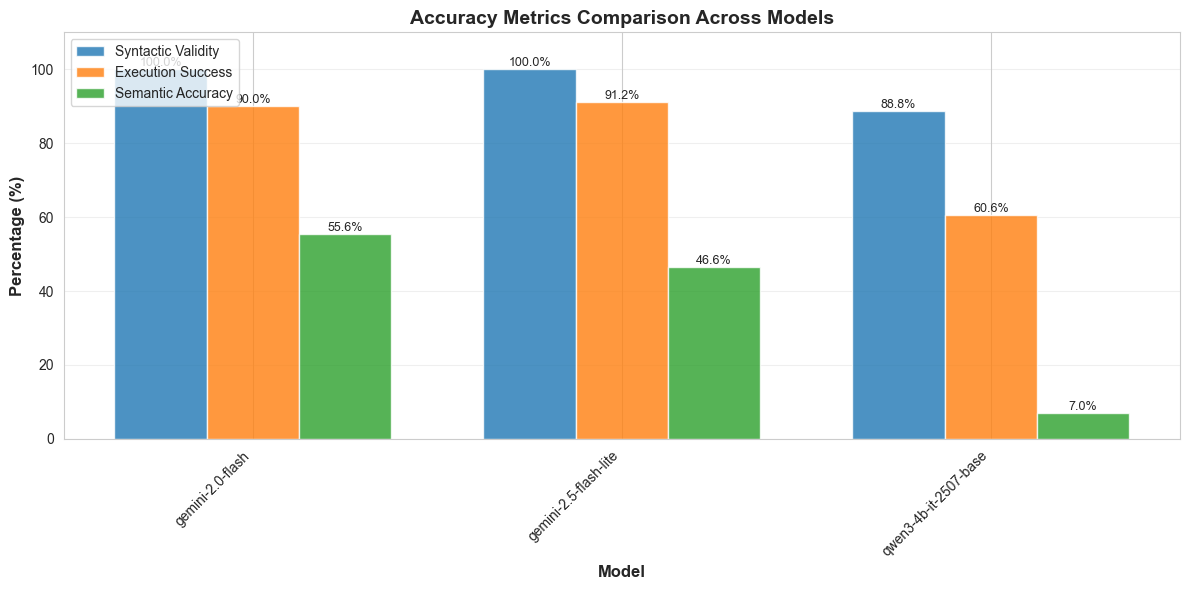

In [42]:
# Visualization 1: Accuracy Metrics Comparison (Bar Chart)

fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data
x = range(len(comparison_df))
width = 0.25

syntactic = comparison_df["Syntactic Validity (%)"]
execution = comparison_df["Execution Success (%)"]
semantic = comparison_df["Semantic Accuracy (%)"]

# Create bars
bars1 = ax.bar([i - width for i in x], syntactic, width, label="Syntactic Validity", alpha=0.8)
bars2 = ax.bar(x, execution, width, label="Execution Success", alpha=0.8)
bars3 = ax.bar([i + width for i in x], semantic, width, label="Semantic Accuracy", alpha=0.8)

# Customize
ax.set_xlabel("Model", fontsize=12, fontweight="bold")
ax.set_ylabel("Percentage (%)", fontsize=12, fontweight="bold")
ax.set_title("Accuracy Metrics Comparison Across Models", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(comparison_df["Model"], rotation=45, ha="right")
ax.set_ylim(0, 110)
ax.legend(loc="upper left")
ax.grid(True, alpha=0.3, axis="y")

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.,
            height,
            f"{height:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9,
        )

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

plt.tight_layout()
plt.show()


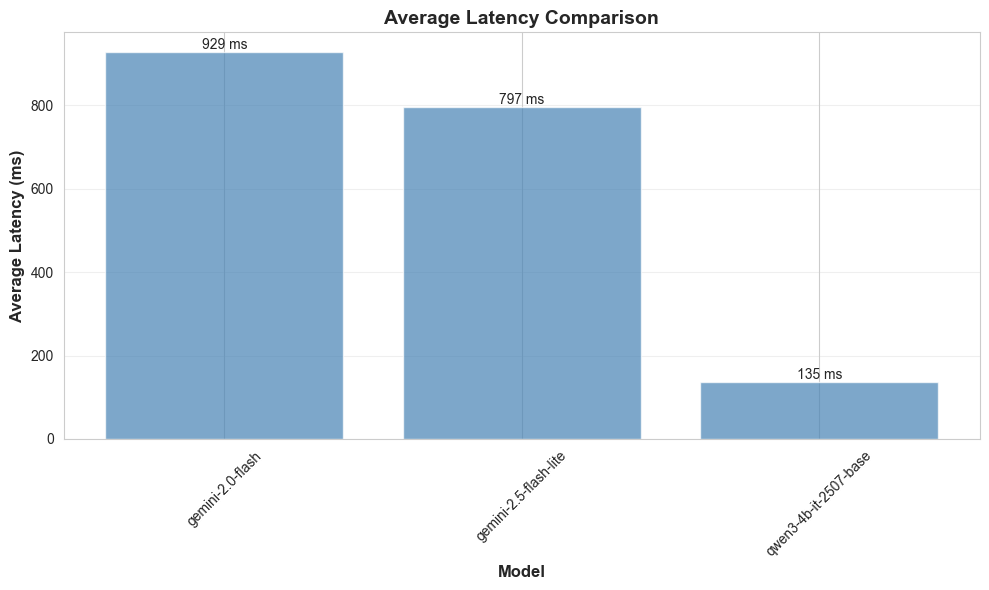

In [43]:
# Visualization 2: Performance Metrics (Latency)

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(
    comparison_df["Model"],
    comparison_df["Avg Latency (ms)"],
    alpha=0.7,
    color="steelblue",
)

ax.set_xlabel("Model", fontsize=12, fontweight="bold")
ax.set_ylabel("Average Latency (ms)", fontsize=12, fontweight="bold")
ax.set_title("Average Latency Comparison", fontsize=14, fontweight="bold")
ax.tick_params(axis="x", rotation=45)
ax.grid(True, alpha=0.3, axis="y")

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.,
        height,
        f"{height:.0f} ms",
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.tight_layout()
plt.show()


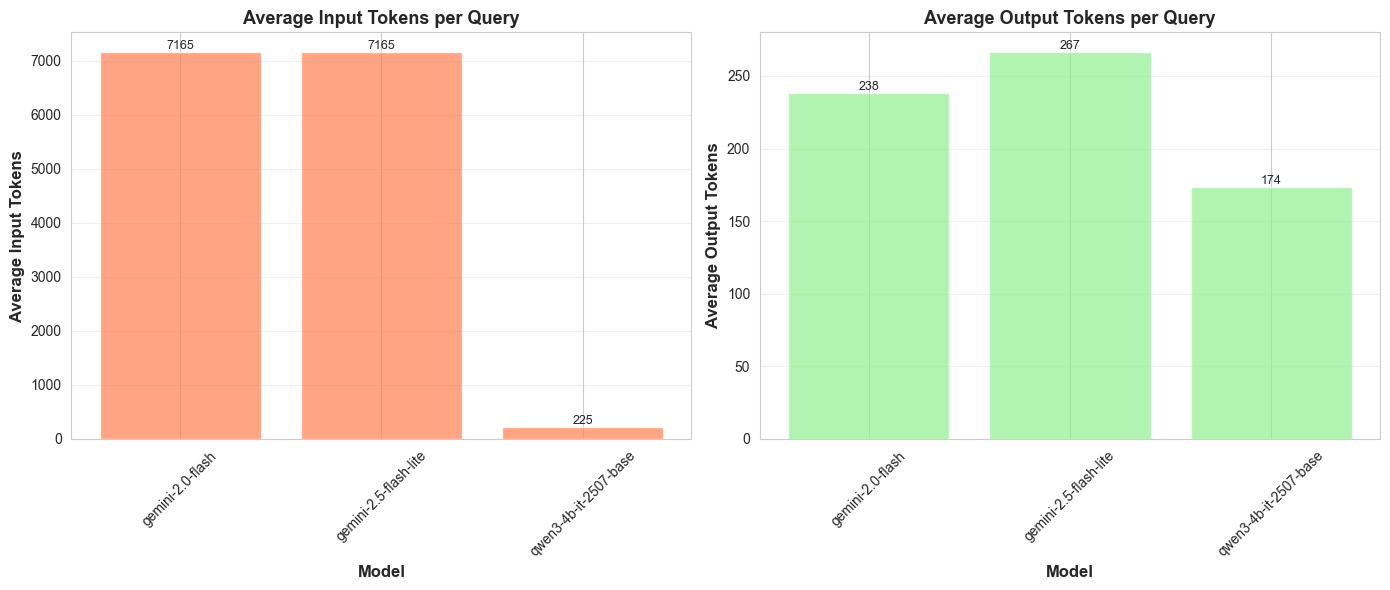

In [44]:
# Visualization 3: Token Usage Comparison

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Input tokens
bars1 = ax1.bar(
    comparison_df["Model"],
    comparison_df["Avg Input Tokens"],
    alpha=0.7,
    color="coral",
)
ax1.set_xlabel("Model", fontsize=12, fontweight="bold")
ax1.set_ylabel("Average Input Tokens", fontsize=12, fontweight="bold")
ax1.set_title("Average Input Tokens per Query", fontsize=13, fontweight="bold")
ax1.tick_params(axis="x", rotation=45)
ax1.grid(True, alpha=0.3, axis="y")

for bar in bars1:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.,
        height,
        f"{height:.0f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

# Output tokens
bars2 = ax2.bar(
    comparison_df["Model"],
    comparison_df["Avg Output Tokens"],
    alpha=0.7,
    color="lightgreen",
)
ax2.set_xlabel("Model", fontsize=12, fontweight="bold")
ax2.set_ylabel("Average Output Tokens", fontsize=12, fontweight="bold")
ax2.set_title("Average Output Tokens per Query", fontsize=13, fontweight="bold")
ax2.tick_params(axis="x", rotation=45)
ax2.grid(True, alpha=0.3, axis="y")

for bar in bars2:
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2.,
        height,
        f"{height:.0f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.tight_layout()
plt.show()


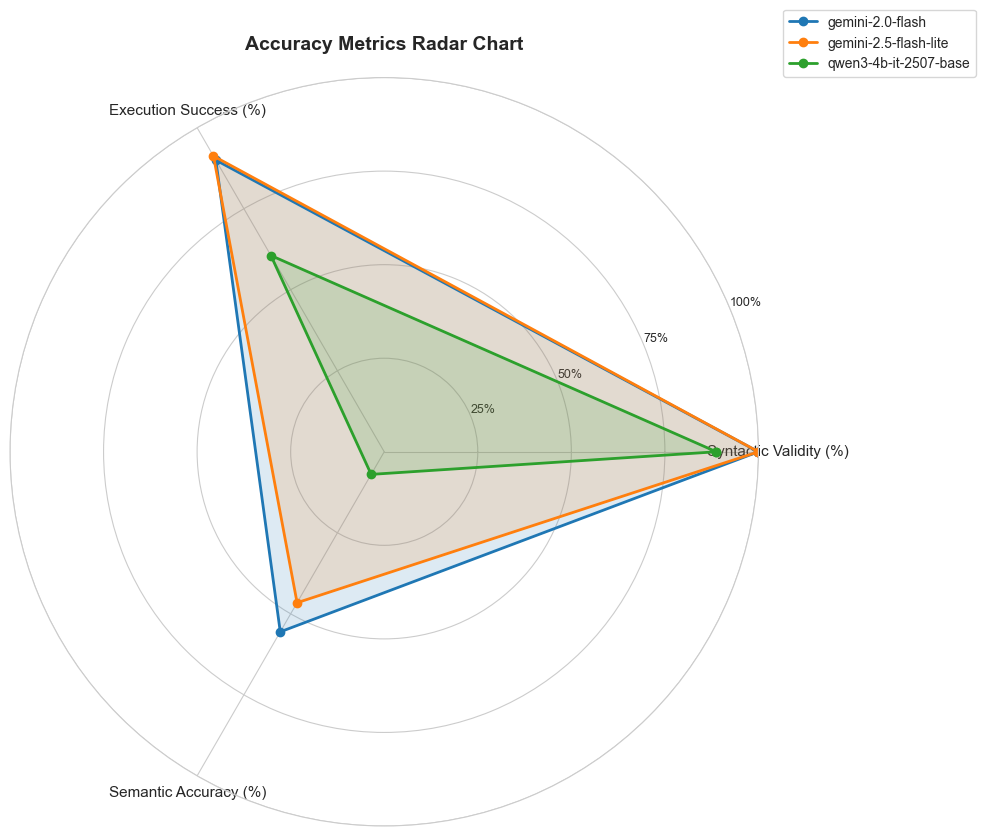

In [45]:
# Visualization 4: Radar/Spider Chart for Overall Performance

from math import pi


def create_radar_chart(df: pd.DataFrame):
    """Create a radar chart comparing normalized metrics."""
    
    # Normalize metrics to 0-100 scale for comparison
    # For latency, invert (lower is better) and normalize
    metrics = ["Syntactic Validity (%)", "Execution Success (%)", "Semantic Accuracy (%)"]
    
    # Set up the radar chart
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection="polar"))
    
    # Compute angles for each metric
    angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
    angles += angles[:1]  # Complete the circle
    
    # Plot each model
    colors = plt.cm.tab10(range(len(df)))
    
    for idx, (_, row) in enumerate(df.iterrows()):
        values = [row[metric] for metric in metrics]
        values += values[:1]  # Complete the circle
        
        ax.plot(angles, values, "o-", linewidth=2, label=row["Model"], color=colors[idx])
        ax.fill(angles, values, alpha=0.15, color=colors[idx])
    
    # Customize
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics, fontsize=11)
    ax.set_ylim(0, 100)
    ax.set_yticks([25, 50, 75, 100])
    ax.set_yticklabels(["25%", "50%", "75%", "100%"], fontsize=9)
    ax.grid(True)
    
    plt.title("Accuracy Metrics Radar Chart", size=14, fontweight="bold", pad=20)
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

create_radar_chart(comparison_df)


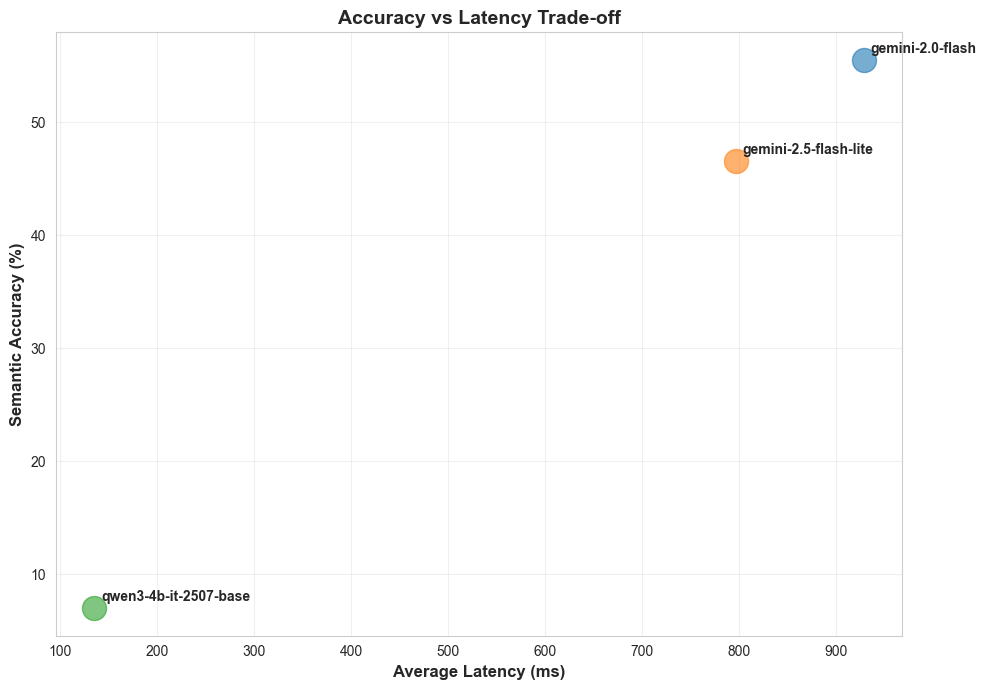

In [46]:
# Visualization 5: Trade-off Analysis (Accuracy vs Latency)

fig, ax = plt.subplots(figsize=(10, 7))

# Scatter plot
for _, row in comparison_df.iterrows():
    ax.scatter(
        row["Avg Latency (ms)"],
        row["Semantic Accuracy (%)"],
        s=300,
        alpha=0.6,
        label=row["Model"],
    )
    ax.annotate(
        row["Model"],
        (row["Avg Latency (ms)"], row["Semantic Accuracy (%)"]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=10,
        fontweight="bold",
    )

ax.set_xlabel("Average Latency (ms)", fontsize=12, fontweight="bold")
ax.set_ylabel("Semantic Accuracy (%)", fontsize=12, fontweight="bold")
ax.set_title("Accuracy vs Latency Trade-off", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [47]:
# Summary Statistics

print("=" * 80)
print("EVALUATION RESULTS SUMMARY")
print("=" * 80)

for _, row in comparison_df.iterrows():
    print(f"\n{row['Model']}:")
    print(f"  Syntactic Validity: {row['Syntactic Validity (%)']:.2f}%")
    print(f"  Execution Success: {row['Execution Success (%)']:.2f}%")
    print(f"  Semantic Accuracy: {row['Semantic Accuracy (%)']:.2f}%")
    print(f"  Avg Latency: {row['Avg Latency (ms)']:.2f} ms")
    print(f"  Avg Input Tokens: {row['Avg Input Tokens']:.0f}")
    print(f"  Avg Output Tokens: {row['Avg Output Tokens']:.0f}")
    print(f"  Test Set Size: {row['Test Set Size']:.0f}")

print("\n" + "=" * 80)

# Best performers
print("\nBEST PERFORMERS:")
print(f"  Highest Semantic Accuracy: {comparison_df.loc[comparison_df['Semantic Accuracy (%)'].idxmax(), 'Model']} ({comparison_df['Semantic Accuracy (%)'].max():.2f}%)")
print(f"  Fastest: {comparison_df.loc[comparison_df['Avg Latency (ms)'].idxmin(), 'Model']} ({comparison_df['Avg Latency (ms)'].min():.2f} ms)")
print(f"  Most Syntactically Valid: {comparison_df.loc[comparison_df['Syntactic Validity (%)'].idxmax(), 'Model']} ({comparison_df['Syntactic Validity (%)'].max():.2f}%)")
print(f"  Best Execution Success: {comparison_df.loc[comparison_df['Execution Success (%)'].idxmax(), 'Model']} ({comparison_df['Execution Success (%)'].max():.2f}%)")


EVALUATION RESULTS SUMMARY

gemini-2.0-flash:
  Syntactic Validity: 100.00%
  Execution Success: 90.00%
  Semantic Accuracy: 55.56%
  Avg Latency: 928.88 ms
  Avg Input Tokens: 7165
  Avg Output Tokens: 238
  Test Set Size: 80

gemini-2.5-flash-lite:
  Syntactic Validity: 100.00%
  Execution Success: 91.25%
  Semantic Accuracy: 46.58%
  Avg Latency: 796.85 ms
  Avg Input Tokens: 7165
  Avg Output Tokens: 267
  Test Set Size: 80

qwen3-4b-it-2507-base:
  Syntactic Validity: 88.75%
  Execution Success: 60.56%
  Semantic Accuracy: 6.98%
  Avg Latency: 135.36 ms
  Avg Input Tokens: 225
  Avg Output Tokens: 174
  Test Set Size: 80


BEST PERFORMERS:
  Highest Semantic Accuracy: gemini-2.0-flash (55.56%)
  Fastest: qwen3-4b-it-2507-base (135.36 ms)
  Most Syntactically Valid: gemini-2.0-flash (100.00%)
  Best Execution Success: gemini-2.5-flash-lite (91.25%)


## Detailed Per-Question Analysis (Optional)

To analyze per-question results, load the summary CSV files:


In [48]:
# Load detailed per-question results (optional)
def load_summary_csvs(results_dir: Path) -> dict[str, pd.DataFrame]:
    """Load all summary CSV files."""
    csv_files = list(results_dir.glob("*_summary.csv"))
    summaries = {}
    
    for csv_file in sorted(csv_files):
        model_name = csv_file.stem.replace("_summary", "")
        df = pd.read_csv(csv_file)
        
        # Convert checkmarks to boolean
        if "syntactic_valid" in df.columns:
            df["syntactic_valid"] = df["syntactic_valid"].apply(lambda x: x == "✓")
        if "execution_success" in df.columns:
            df["execution_success"] = df["execution_success"].apply(lambda x: x == "✓")
        if "result_match" in df.columns:
            df["result_match"] = df["result_match"].apply(lambda x: x == "✓")
        
        summaries[model_name] = df
        print(f"Loaded {len(df)} records for {model_name}")
    
    return summaries

# Uncomment to load detailed results
# detailed_results = load_summary_csvs(RESULTS_DIR)
# print(f"\nLoaded {len(detailed_results)} detailed result sets")


In [49]:
# Example: Compare per-question results across models (optional)
# Uncomment to run

# if 'detailed_results' in globals() and detailed_results:
#     # Find questions where models differ
#     all_ids = set()
#     for df in detailed_results.values():
#         all_ids.update(df['id'])
#     
#     comparison_detailed = []
#     for qid in sorted(all_ids):
#         row = {'id': qid}
#         for model_name, df in detailed_results.items():
#             model_row = df[df['id'] == qid]
#             if not model_row.empty:
#                 row[model_name] = '✓' if model_row.iloc[0]['result_match'] else '✗'
#             else:
#                 row[model_name] = 'N/A'
#         comparison_detailed.append(row)
#     
#     comparison_detailed_df = pd.DataFrame(comparison_detailed)
#     display(comparison_detailed_df.head(20))
